# Nanobeam cavity

1D photonic crystal cavities, also known as nanobeam cavities, are widely used in photonics and quantum optics due to their high-quality factors (Q-factors) and low mode volumes. These attributes make them ideal for exploiting Purcell enhancement, which is crucial for applications involving quantum emitters. The cavities consist of a one-dimensional array of unit cells acting as Bragg mirrors surrounding a tapered region. In this region, the photonic bandgap is gently shifted, allowing the accommodation of an optical mode with minimal scattering and a high-quality factor. In other dimensions, the light confinement is due to total internal reflection.

In this notebook, we will implement the basic simulation for such cavities, and go through analysis procedures to calculate mode volume and Q-factors, without the need to run the simulation until the total decay of the fields, which is not practical for high-Q cavities. The Q-factor is a figure of merit related to the photon lifetime in the cavity; hence, a high Q-factor means that the fields in the cavity will decay slowly over time. The mode volume is a metric to evaluate the volumetric distribution of the mode; a low mode volume indicates a highly concentrated field. To explore Purcell enhancement, a cavity with a high Q-factor and low mode volume is needed.

 As a reference, we will reproduce the results of the work of `Parag B. Deotare, Murray W. McCutcheon, Ian W. Frank,
Mughees Khan,and Marko Lončar, "High quality factor photonic crystal nanobeam cavities", Applied Physics Letters 94(12), (2009).` [DOI: https://doi.org/10.1063/1.3107263](https://doi.org/10.1063/1.3107263).

The design consists of two stacks of unit cells that will act as mirrors, and a tapered region, where the parameters of the unit cell are modified given a polynomial function, to reduce abrupt mode mismatch and avoid scattering. It is possible to explore asymmetries in the cavities, reducing the number of unit cells in one direction and adding a tapered region at its end, allowing efficient light extraction with tapered fiber optics.

<img src="img/NanobeamCavity_1.png" width="400" alt="Schematic of the experiment">


For more information, please refer to our [learning center](https://www.flexcompute.com/tidy3d/examples/), where you can find tutorials and examples on how to carry out [band structure calculation](https://www.flexcompute.com/tidy3d/examples/notebooks/Bandstructure/), use the [resonance finder plugin](https://www.flexcompute.com/tidy3d/examples/notebooks/ResonanceFinder/) and how to calculate [Q-factor and mode volume for a 2D photonic crystal cavity](https://www.flexcompute.com/tidy3d/examples/notebooks/CavityFOM/)


In [1]:
import tidy3d as td
import numpy as np
import matplotlib.pyplot as plt
from tidy3d import web
from typing import Callable
# defining a random seed for reproducibility
np.random.seed(12)

## Auxiliary Functions

We will start defining some auxiliary functions to help us set up the simulation.

Since for using the [resonance finder plugin](https://www.flexcompute.com/tidy3d/examples/notebooks/ResonanceFinder/) it is necessary to analyze the fields after the source decays, we will define a simple function to estimate the decay time of the source, given the relation of the temporal width ($\Delta t$) and the spectral linewidth ($\Delta  \nu$) of a gaussian pulse $\Delta t \Delta \nu \approx 0.44$, and the `offset` attribute of the `source_time`object.

In [2]:
def find_source_decay(source):
    # source bandwidth
    fwidth = source.source_time.fwidth

    # time offset to start the source
    time_offset = source.source_time.offset / (2 * np.pi * fwidth)

    # time width for a gaussian pulse
    pulse_time = 0.44 / fwidth

    decay_time = time_offset + pulse_time
    return decay_time

Next, we will define the function to return the tapered parameter as a function of the unit cell position. A given parameter in the tapered region will follow the definition:

$P_{tapered}(x) = P[1 - M_d(2x^3 -3x^2 + 1)]$

Where $x \equiv \frac{\text{unit cell index}}{\text{number of tapered unit cells}}$, and the unit cell at the center is indexed as 0. Hence $x$ ranges from 0 to 1, so the center unit cell would have a given parameter as $P(1- M_d)$.

The $M_d$ parameter is a number ranging from $[0,1)$ and is interpreted as the maximum reduction of a given parameter, in proportion to its original value. For example, $M_d = 0.3$ means that the smallest value of this parameter will be 30% less than its original value.



In [3]:
def taper_factor(
    max_dip,
    structure_index,
    n_tapered_structures,
    cubic_factor=2,
    quadratic_factor=-3,
    linear_factor=0,
    offsetFactor=1,
):
    cubic = cubic_factor
    quadratic = quadratic_factor
    linear = linear_factor
    offset = offsetFactor

    """
    Compute a taper factor using a cubic polynomial.

    Parameters:
    - max_dip: float, maximum dip in taper factor.
    - structure_index: int, index of the current structure.
    - n_tapered_structures: int, total number of tapered structures.
    - cubic_factor: float, coefficient for cubic term (default 2).
    - quadratic_factor: float, coefficient for quadratic term (default -3).
    - linear_factor: float, coefficient for linear term (default 0).
    - offsetFactor: float, constant offset (default 1).

    Returns:
    - float, the taper factor for the given structure.
    """

    # to avoid division for 0 in a case where there is no tapered region
    if n_tapered_structures == 0:
        x = 1
    else:
        x = structure_index / np.ceil(n_tapered_structures / 2)

    # factor is 1 if the structure is not in the tapered region
    factor = (
        1
        if x >= 1
        else 1 - max_dip * (cubic * x**3 + quadratic * x**2 + linear * x + offset)
    )

    return factor

To reduce the computational cost, we can exploit mirror symmetries of the problem to reduce the computational size up to 8 times. However, to properly set the symmetries parity, it is necessary to consider the polarization and vectorial nature of the fields.  For more information on how to set up symmetries and their relation with source polarization, please refer to our [symmetries tutorial](https://www.flexcompute.com/tidy3d/examples/notebooks/Symmetry/).

The function defined below will generate the right symmetry parity for a given polarization.

In [4]:
def get_symmetry(polarization):
    if polarization == "Ex":
        sym = [-1, 1, 1]
    elif polarization == "Ey":
        sym = [1, -1, 1]
    elif polarization == "Ez":
        sym = [1, 1, -1]
    elif polarization == "Hz":
        sym = [-1, -1, 1]
    elif polarization == "Hy":
        sym = [-1, 1, -1]
    elif polarization == "Hx":
        sym = [1, -1, -1]
    return sym

## Simulation Setup

Now, we will start creating functions to set up the simulation.

First, we will define a function that creates a stack of unit cells on one side of the nanobeam, positioning them correctly and defining the appropriate tapered parameter. Since unit cell assembly is consistent across different types, the function will accept a `unit_cell_function` argument, which returns the unit cell geometry. Additionally, it requires a list of original parameter arguments (`original_params`) and a list of the $Md$ parameters (`max_dip_params`).


Note that `n_tapered_structures` refers to the total number of tapered unit cells on both sides of the nanobeam. Hence, if there is an odd number of unit cells, the first one is exactly in the middle. Otherwise, it is separated by a lattice constant from its twin on the other side, plus a gap (`central_gap` argument). The definition of `n_constant_structures` refers to the mirror cells on each side.

In [5]:
def assemble_unit_cells(
    unit_cell_function: Callable,
    lattice_constant: float,
    max_dip_lattice: float,
    n_constant_structures: int,
    n_tapered_structures: int,
    original_params: list,
    max_dip_params: list,
    central_gap: float = 0,
):
    """
    Assemble unit cells into a structure with tapered lattice constants and parameters.

    Parameters:
    - unit_cell_function: callable, function to generate a unit cell given position and parameters.
    - lattice_constant: float, base lattice constant for the unit cells.
    - max_dip_lattice: float, maximum dip for tapering the lattice constant.
    - n_constant_structures: int, number of constant lattice structures on either side.
    - n_tapered_structures: int, total number of tapered structures.
    - original_params: list of floats, original parameters to be tapered (default empty list).
    - max_dip_params: list of floats, maximum dips for each parameter to be tapered (default empty list).
    - central_gap: float, gap between central unit cells (only valid for an odd number of tapered structures).

    Returns:
    - unit_cells: combined unit cells as generated by the unit_cell_function.
    - pos_x: final position of the last unit cell in the x-direction.
    """

    unit_cells = None

    # start position
    pos_x = 0

    # defining the number of unit cells for each side
    positions = range(
        n_constant_structures
        + int(np.floor(n_tapered_structures / 2))
        + n_constant_structures % 2
    )

    # iterating over the unit cells
    for i in positions:
        # defining the current value of the unit cell given the position
        current_lattice_constant = lattice_constant * taper_factor(
            max_dip_lattice, i, n_tapered_structures
        )

        # condition for odd or even number of unit cells
        if i == 0:
            if n_tapered_structures % 2 != 0:
                pos_x = 0
            else:
                pos_x = central_gap / 2 + current_lattice_constant / 2
        else:
            pos_x += current_lattice_constant / 2 + previous_lattice_constant / 2

        # now we create a list of parameters to input to the unit_cell_function
        parameters = []
        for idx in range(len(original_params)):
            original = original_params[idx]
            max_dip = max_dip_params[idx]
            tapered_param = original * taper_factor(
                max_dip, i, n_tapered_structures
            )
            parameters.append(tapered_param)

        # defining the center
        center = (pos_x, 0, 0)

        # creating the unit cell calling the unit_cell_function
        new_unit_cell = unit_cell_function(center, *parameters)

        # adding the unit cell to the geometry (or initializing the variable if is the first unit cell)
        unit_cells = new_unit_cell if unit_cells == None else unit_cells + new_unit_cell

        # the separation to the next unit cell is the mean value of the lattice constants of the current and next unit cells
        previous_lattice_constant = current_lattice_constant

    # return the geometry and the position of the last unit cell
    return unit_cells, pos_x

### Unit cell functions

As an example, we will create 3 different unit cell functions. The first two are simple functions to return elliptical and square unit cells. The third one is an example of more complex geometry using the [PolySlab](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PolySlab.html).

Given the definition `assemble_unit_cells` function, the first argument must be the center of the geometry object, and non-taper parameters must be passed as default arguments.

In [6]:
# function for creating ellipse unit cells
def ellipse_uc(center, x_axis, y_axis, height=0.5):
    theta = np.linspace(0, np.pi * 2, 1001)
    x = x_axis * np.cos(theta) + center[0]
    y = y_axis * np.sin(theta) + center[1]

    geometry = td.PolySlab(
        vertices=np.array([x, y]).T,
        slab_bounds=(-height / 2 + center[2], height / 2 + center[2]),
        axis=2,
    )
    return geometry


# function for creating ellipse unit cells
def square_uc(center, x_size, y_size, height=0.5):
    geometry = td.Box(center=center, size=(x_size, y_size, height))
    return geometry


# function for creating "sawfish" unit cells
def sawfish_uc(center, x, y, height=0.5, width=0.1):
    e = 6

    yArray = []
    numPoints = 501

    # defining the vertices for the PolySlab
    xaxis = np.linspace(center[0] - x / 2, center[0] + x / 2, numPoints)
    xArray = np.linspace(-x / 2, x / 2, numPoints)
    yArray = y * ((np.cos((np.pi / x) * xArray)) ** e) + width / 2
    yArray2 = -y * ((np.cos((np.pi / x) * np.flip(xArray))) ** e) - width / 2

    X = np.concatenate([xaxis, np.flip(xaxis)])
    Y = np.concatenate([yArray, yArray2])
    arr = np.array([X, Y]).T

    geometry = td.PolySlab(
        vertices=arr,
        slab_bounds=(-height / 2, height / 2),
        axis=2,
    )

    return geometry

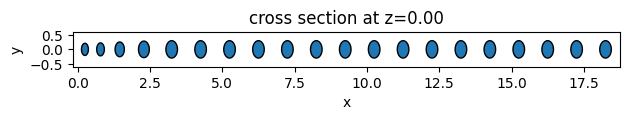

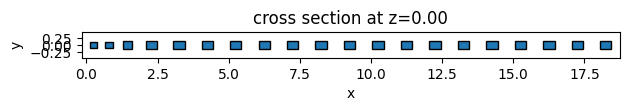

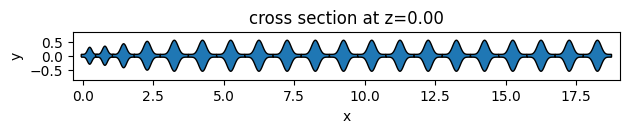

In [7]:
# plot the geometries

args = dict(
    lattice_constant=1,
    max_dip_lattice=0.5,
    n_constant_structures=15,
    n_tapered_structures=8,
)

ellipse_geometry, _ = assemble_unit_cells(
    unit_cell_function=ellipse_uc,
    original_params=[0.2, 0.3],
    max_dip_params=[0.4, 0.3],
    **args
)
ellipse_geometry.plot(z=0)

square_geometry, _ = assemble_unit_cells(
    unit_cell_function=square_uc,
    original_params=[0.4, 0.3],
    max_dip_params=[0.4, 0.3],
    **args
)
square_geometry.plot(z=0)

sawfish_geometry, _ = assemble_unit_cells(
    unit_cell_function=sawfish_uc,
    original_params=[1, 0.5],
    max_dip_params=[0.4, 0.5],
    **args
)
sawfish_geometry.plot(z=0)

plt.show()

### Source and monitors

Auxiliary function for creating the [point dipole source](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PointDipole.html)

In [8]:
def create_source(
    polarization="Ey",
    wl1=0.7,
    wl2=1.0,
    center=(0, 0, 0),
):
    # defining the frequencies based on the given wavelengths
    freq1 = td.C_0 / wl1
    freq2 = td.C_0 / wl2
    freq0 = (freq1 - freq2) / 2 + freq2
    fwidth = (freq1 - freq2) / 2

    # defining the source
    source = td.PointDipole(
        center=center,
        name="pointDipole",
        polarization=polarization,
        source_time=td.GaussianPulse(
            freq0=freq0, fwidth=fwidth, phase=2 * np.pi * np.random.random()
        ),
    )

    return source

Function for creating the monitors.

For this simulation we will have distinct types of monitors:

1. Some point [`FieldTimeMonitor`](https:/`docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldTimeMonitor.html), that will record the fields as a function of time in different positions of the cavity, and will be used for Q-factor and resonant frequency calculation

2. Six [`FluxTimeMonitor`](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FluxTimeMonitor.html) surrounding the simulation domain, that will be used for discriminating the directions of losses, and calculation of directional Q-factors.

3. One 3D `FieldTimeMonitor` for calculating the total energy at the end of the simulation. To reduce memory requirements, we will set the `interval_space` as `(5,5,5)`, which means that we will record fields at each five grid points in all directions.

4. One planar `FieldTimeMonitor`, also recorded at the end of the simulation, to show the field profile. 


Note that, in principle, it would be possible to use a frequency-domain monitor to visualize the resonant mode profile. However, the exact resonance frequency is often not known beforehand, therefore it is difficult the set the exact frequency to visualize. On the other hand, setting the time field monitors to record only a fell oscillation cycle at the end of the simulation ensures that only the resonant modes are being recorded, as the other frequencies have already decayed.

In [9]:
def create_monitors(
    simulation,
    n_point_monitors=5,
    center=(0, 0, 0),
    deviation=(0.2, 0, 0),
):
    simulation_size = simulation.size

    freq0 = simulation.sources[0].source_time.freq0

    # creating random positions around the center of the cavity
    positions = np.random.random((n_point_monitors, 3)) * np.array(deviation) + center

    # creating the randomly positioned monitors
    point_monitors = [
        td.FieldTimeMonitor(
            center=tuple(positions[i]),
            name="pointMon%i" % i,
            start=0,
            size=(0, 0, 0),
            interval=1,
        )
        for i in range(n_point_monitors)
    ]

    # defining size for the 3D field monitor
    size = tuple(np.array(simulation_size) * 0.9)

    # defining the start time of the monitors to record only the last two oscillations of the field
    start = simulation.run_time - 2 / freq0

    # 3D field monitor for energy density calculation
    field_monitor = td.FieldTimeMonitor(
        center=(0, 0, 0),
        size=size,
        start=start,
        name="fieldTimeMon",
        interval_space=(5, 5, 5),
    )

    # 2D field monitor for visualizing the resonant mode profile
    field_profile_monitor = td.FieldTimeMonitor(
        center=(0, 0, 0),
        size=(td.inf, td.inf, 0),
        start=start,
        name="fieldProfileMon",
    )

    # setup planar flux monitors surrounding the simulation volume
    flux_monitors = []
    for i in [-1, 1]:
        for j in [(0.5, 0, 0), (0, 0.5, 0), (0, 0, 0.5)]:
            j = np.array(j)
            # defining the center
            mon_center = tuple(np.array(size) * j * i + -1 * i * j * (0.95, 0.95, 0.95))

            # defining the size
            j2 = np.array([0 if l == 0.5 else 1 for l in j])
            mon_size = tuple(np.array(size) * j2 * 2)

            # defining the name
            mon_name = np.array(["x", "y", "z"])[np.ceil(j).astype(bool)][0]
            mon_name = ("-" + mon_name) if i == -1 else mon_name

            # creating the monitors
            flux_monitors.append(
                td.FluxTimeMonitor(
                    center=mon_center, size=mon_size, start=start, name=mon_name
                )
            )

    return (
        point_monitors
        + flux_monitors
        + [
            field_monitor,
            field_profile_monitor,
        ]
    )

Function for creating simulation object. Since many simulation parameters such as symmetry and source positions depend on the final nanobeam structure, it is convenient to wrap everything in a single function.

In [10]:
def create_simulation(
    wl1: float,
    wl2: float,
    width: float,
    height: float,
    unit_cell_function: Callable,
    lattice_constant: float,
    n_constant_structures_right: int,
    n_constant_structures_left: int,
    n_tapered_structures: int,
    n_tapered_output: int,
    max_dip_lattice: float,
    original_params: list,
    max_dip_params: list,
    polarization: str,
    unit_cell_index: int,
    waveguide_index: float,
    run_time: float = 2e-12,
    central_gap: float = 0,
    delta_override: float = 0.01,
    substrate_index: float = 1,
    medium_index: float = 1,
    sidewall_angle: float = 0,
):
    """
    create a simulation with specified parameters and unit cells.

    Parameters:
    - wl1: float, wavelength 2.
    - wl2: float, wavelength 2 for the simulation.
    - width: float, width of the waveguide structure.
    - height: float, height of the structure.
    - unit_cell_function: callable, function to generate unit cells.
    - delta_override: float, spacing for mesh override.
    - lattice_constant: float, lattice constant.
    - n_constant_structures_right: int, number of constant structures on the right side of the nanobeam.
    - n_constant_structures_left: int, number of constant structures on the left side of the nanobeam.
    - n_tapered_structures: int, number of tapered structures at the cavity region.
    - n_tapered_waveguide: int, number of tapered unit cells at the right end of the nanobeam.
    - max_dip_lattice: float, maximum dip for the lattice constant tapering.
    - original_params: list, list with the unit cell params.
    - max_dip_params: list, list with the tapering params
    - polarization: str, polarization of the source.
    - unit_cell_index: int, index for the unit cell structure.
    - waveguide_index: float, index for the waveguide.
    - run_time: float, total run time for the simulation.
    - central_gap: float, central gap between structures (if n_tapered_structures is odd).
    - substrate_index: float, index for the substrate material.
    - medium_index: float, index for the surrounding medium.
    - sidewall_angle: float, waveguide sidewall angle.

    Returns:
    - sim: the simulation object with defined structures, sources, and monitors.
    """

    # define the mesh override at the cavity region
    mesh_override = td.MeshOverrideStructure(
        geometry=td.Box(center=(0, 0, 0), size=(4, width, height)),
        dl=(delta_override,) * 3,
    )

    # define grid specification for the simulation
    grid_spec = td.GridSpec.auto(
        min_steps_per_wvl=15,
        override_structures=[mesh_override],
    )

    kwargs = dict(unit_cell_function=unit_cell_function,
                  lattice_constant=lattice_constant,
                  max_dip_lattice=max_dip_lattice,
                  original_params=original_params,
                  max_dip_params=max_dip_params,
                  central_gap=central_gap)

    # assemble unit cells for the right side of the nanobeam
    unit_cells_right, pos_x_right = assemble_unit_cells(
        n_constant_structures=n_constant_structures_right,
        n_tapered_structures=n_tapered_structures,
        **kwargs
    )

    # assemble unit cells for the left side of the nanobeam
    unit_cells_left, pos_x_left = assemble_unit_cells(
        n_constant_structures=n_constant_structures_left,
        n_tapered_structures = n_tapered_structures,
        **kwargs
    )

    # rotate and adjust the position of the left unit cells
    unit_cells_left = unit_cells_left.rotated(np.pi, axis=2)
    pos_x_left *= -1

    # assemble and position the tapered output if applicable
    if n_tapered_output > 0:
        waveguide_tapered, pos_tapered = assemble_unit_cells(
            n_constant_structures=0,
            n_tapered_structures=n_tapered_output * 2,
            **kwargs
        )

        # rotate and position the tapered output
        waveguide_tapered = waveguide_tapered.rotated(np.pi, axis=2)
        waveguide_tapered = waveguide_tapered.translated(
            x=pos_x_right + lattice_constant + pos_tapered, y=0, z=0
        )

        # combine the left, right, and tapered waveguide geometries
        nanobeam_geometry = unit_cells_left + unit_cells_right + waveguide_tapered

    else:
        pos_tapered = 0
        nanobeam_geometry = unit_cells_left + unit_cells_right

    # calculate sizes and defining the center of the nanobeam geometry
    size_left = abs(pos_x_left) + lattice_constant + wl2 / 2
    size_right = abs(pos_x_right + pos_tapered) + lattice_constant + wl2 / 2
    nanobeam_size = size_left + size_right
    nanobeam_center = size_left - nanobeam_size / 2

    # recenter the geometry to optimize the simulation space
    nanobeam_geometry = nanobeam_geometry.translated(x=nanobeam_center, y=0, z=0)

    # define mediums for the substrate and nanobeam materials
    nanobeam_medium = td.Medium(permittivity=unit_cell_index**2)

    # create the nanobeam structure
    nanobeam_structure = td.Structure(
        geometry=nanobeam_geometry,
        medium=nanobeam_medium,
    )

    # define the waveguide geometry
    cell_size = (
        nanobeam_size,
        width + 2 * wl2,
        height + 2 * wl2,
    )

    # defining the waveguide. Use a PolySlab for the sidewall angle
    geometry_wvg = td.PolySlab(
        vertices=[
            [-2 * cell_size[0], width / 2],
            [2 * cell_size[0], width / 2],
            [2 * cell_size[0], -width / 2],
            [-2 * cell_size[0], -width / 2],
        ],
        axis=2,
        slab_bounds=(-height / 2, height / 2),
        sidewall_angle=sidewall_angle,
    )
    waveguide = td.Structure(
        geometry=geometry_wvg,
        medium=td.Medium(permittivity=waveguide_index**2),
    )

    # substrate
    substrate = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-999, -999, -999), rmax=(999, 999, -height / 2)
        ),
        medium=td.Medium(permittivity=substrate_index**2),
    )

    # defining the source
    sources = [
        create_source(
            polarization=polarization,
            wl1=wl1,
            wl2=wl2,
            center=(nanobeam_center, 0, 0),
        )
    ]

    # boundary conditions
    boundary_spec = td.BoundarySpec(
        x=td.Boundary.pml(), y=td.Boundary.pml(), z=td.Boundary.pml()
    )

    # determine symmetry based on structure configuration
    if (n_constant_structures_left == n_constant_structures_right) and (
        n_tapered_output == 0
    ):
        symmetry = get_symmetry(polarization=polarization)
    else:
        symmetry = [0] + get_symmetry(polarization=polarization)[1:]

    # create the simulation object
    sim = td.Simulation(
        size=cell_size,
        structures=[substrate, waveguide, nanobeam_structure],
        sources=sources,
        monitors=[],
        run_time=run_time,
        boundary_spec=boundary_spec,
        grid_spec=grid_spec,
        symmetry=symmetry,
        medium=td.Medium(permittivity=medium_index**2),
    )

    # add monitors to the simulation
    monitors = create_monitors(
        sim, n_point_monitors=5, center=(nanobeam_center, 0, 0), deviation=(0.5, 0, 0)
    )
    return sim.updated_copy(monitors=monitors)

### Running the simulation

Finally, we will set the parameters as reported in the reference [paper](https://doi.org/10.1063/1.3107263) and run the simulation.

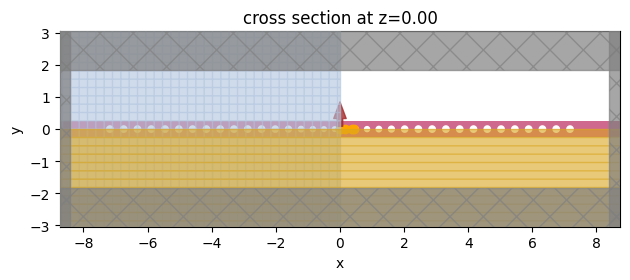

In [11]:
height = 0.22
width = 0.5
lattice_constant = 0.430
max_dip_lattice = 1 - 0.330 / lattice_constant
radius_x = 0.28 * lattice_constant
radius_y = radius_x
max_dip_x = 0
max_dip_y = 0
n_constant_cells = 12  # each side
n_tapered_cells = 12  # total
central_gap = 0
wl1 = 1.4
wl2 = 1.6
run_time = 5e-12
polarization = "Ey"
substrate_index = 1.44
unit_cell_index = 1
waveguide_index = 3.5
sidewall_angle = 0

# defining a unit cell function depending only on the taper parameters
unit_cell_function = lambda center, x, y: ellipse_uc(
    center, x_axis=x, y_axis=y, height=height
)


sim = create_simulation(
    unit_cell_function=unit_cell_function,
    wl1=wl1,
    wl2=wl2,
    width=width,
    height=height,
    run_time=run_time,
    lattice_constant=lattice_constant,
    n_constant_structures_right=n_constant_cells,
    n_constant_structures_left=n_constant_cells,
    n_tapered_output=0,
    n_tapered_structures=n_tapered_cells,
    max_dip_lattice=max_dip_lattice,
    polarization=polarization,
    substrate_index=substrate_index,
    unit_cell_index=unit_cell_index,
    waveguide_index=waveguide_index,
    sidewall_angle=sidewall_angle,
    original_params=[radius_x, radius_y],
    max_dip_params=[max_dip_lattice, max_dip_lattice],
)


sim.plot(z=0, monitor_alpha=0)
plt.show()

In [12]:
# estimating the cost
task_id = web.upload(sim, "nanobeam_test")
cost = web.estimate_cost(task_id)

16:38:24 -03 Created task 'nanobeam_test' with task_id                          
             'fdve-d8b00709-3576-4dc6-b35d-85d058bfc1ac' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=632346;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d8b00709-3576-4dc6-b35d-85d058bfc1ac\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=421719;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d8b00709-3576-4dc6-b35d-85d058bfc1ac\taskId]8;;\]8;id=632346;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d8b00709-3576-4dc6-b35d-85d058bfc1ac\=]8;;\]8;id=492985;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d8b00709-3576-4dc6-b35d-85d058bfc1ac\fdve]8;;\]8;id=632346;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d8b00709-3576-4dc6-b35d-85d058bfc1ac\-d8b00709-357]8;;\
             ]8;id=632346;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d8b00709-3576-4dc6-b35d-85d058bfc1ac\6-4dc6-b35d-85d058bfc1ac']8;;\.

Output()

16:38:28 -03 Maximum FlexCredit cost: 0.100. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

In [13]:
# running the simulation
sim_data = web.run(simulation=sim, task_name="ellipse_nanobeam")

             Created task 'ellipse_nanobeam' with task_id                       
             'fdve-673c97b4-e271-4281-80f3-ba34d94a36b6' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=384434;https://tidy3d.simulation.cloud/workbench?taskId=fdve-673c97b4-e271-4281-80f3-ba34d94a36b6\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=743701;https://tidy3d.simulation.cloud/workbench?taskId=fdve-673c97b4-e271-4281-80f3-ba34d94a36b6\taskId]8;;\]8;id=384434;https://tidy3d.simulation.cloud/workbench?taskId=fdve-673c97b4-e271-4281-80f3-ba34d94a36b6\=]8;;\]8;id=983162;https://tidy3d.simulation.cloud/workbench?taskId=fdve-673c97b4-e271-4281-80f3-ba34d94a36b6\fdve]8;;\]8;id=384434;https://tidy3d.simulation.cloud/workbench?taskId=fdve-673c97b4-e271-4281-80f3-ba34d94a36b6\-673c97b4-e27]8;;\
             ]8;id=384434;https://tidy3d.simulation.cloud/workbench?taskId=fdve-673c97b4-e271-4281-80f3-ba34d94a36b6\1-4281-80f3-ba34d94a36b6']8;;\.

Output()

16:38:32 -03 status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

16:38:48 -03 status = preprocess

16:38:49 -03 Maximum FlexCredit cost: 0.100. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

Output()

16:42:41 -03 status = postprocess

16:43:22 -03 status = success

             View simulation result at                                          
             ]8;id=388517;https://tidy3d.simulation.cloud/workbench?taskId=fdve-673c97b4-e271-4281-80f3-ba34d94a36b6\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=909941;https://tidy3d.simulation.cloud/workbench?taskId=fdve-673c97b4-e271-4281-80f3-ba34d94a36b6\taskId]8;;\]8;id=388517;https://tidy3d.simulation.cloud/workbench?taskId=fdve-673c97b4-e271-4281-80f3-ba34d94a36b6\=]8;;\]8;id=997105;https://tidy3d.simulation.cloud/workbench?taskId=fdve-673c97b4-e271-4281-80f3-ba34d94a36b6\fdve]8;;\]8;id=388517;https://tidy3d.simulation.cloud/workbench?taskId=fdve-673c97b4-e271-4281-80f3-ba34d94a36b6\-673c97b4-e27]8;;\
             ]8;id=388517;https://tidy3d.simulation.cloud/workbench?taskId=fdve-673c97b4-e271-4281-80f3-ba34d94a36b6\1-4281-80f3-ba34d94a36b6']8;;\.

Output()

16:44:25 -03 loading simulation from simulation_data.hdf5

16:44:26 -03 WARNING: Simulation final field decay value of 0.268 is greater    
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

It is possible to notice a warning at the end of the simulation, stating that the fields haven't completely decayed. This is expected for high Q-factor cavities, and the suggestion to run with a larger `run_time` can be ignored in this case.

## Data Analysis

First, we will plot the electric field profile at the end of the simulation, where it is possible to observe a tightly confined mode.

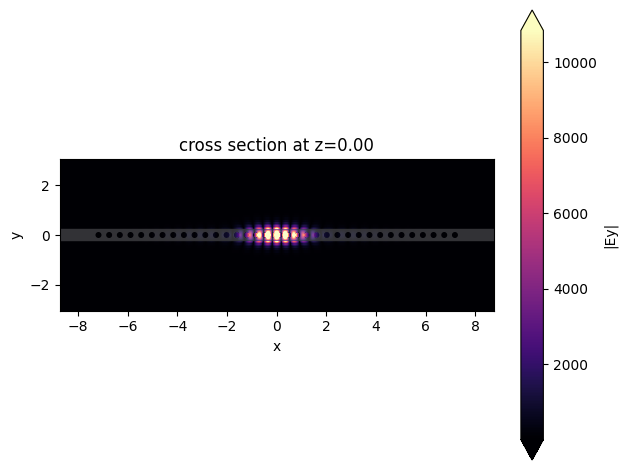

In [14]:
sim_data.plot_field(
    "fieldProfileMon",
    "Ey",
    val="abs",
    z=0,
    t=sim_data["fieldProfileMon"].Ez.t[-1],
)
plt.show()

### Resonance and Q-factor analysis

Next, we will collect the data for the point field monitors and use the `ResonaceFinder` plugin that implements the harmonic-inversion algorithm, which is a convenient technique to analyze exponential decaying fields, allowing us to get Q-factor information with a relatively short simulation time.

For high Q-factor cavities (greater than $10^6$) a larger run time may be needed, as well as fine-tuning of the `freq_window` parameters, which is the frequency window where the resonances will be analyzed. 

Since the harmonic-inversion technique is valid for exponential decaying fields, we will only analyze the data after the sources decay.

In [15]:
def analyse_resonance_monitors(sim_data, start_time=1e-12, freq_window=None):
    # importing needed libraries
    from tidy3d.plugins.resonance import ResonanceFinder

    combinedSignal = 0
    polarization = sim_data.simulation.sources[0].polarization

    # iterate through all monitors and combine the signal
    i = 0
    name = "pointMon%i" % i
    while name in sim_data.monitor_data:
        combinedSignal += sim_data["pointMon0"].field_components[polarization].squeeze()
        i += 1
        name = "pointMon%i" % i

    # create the ResonanceFinder instance
    rf = ResonanceFinder(freq_window=freq_window)

    # boolean mask to set the data after source decay
    bm = combinedSignal.t >= start_time

    # data containing the resonance information
    data = rf.run_raw_signal(combinedSignal[bm], sim_data.simulation.dt)

    # creating a DataFrame
    df = data.to_dataframe()
    df["wl"] = (td.C_0 / df.index) * 10**3

    return df, combinedSignal

In [16]:
# defining the frequency window
freq0 = sim_data.simulation.sources[0].source_time.freq0
fwidth = sim_data.simulation.sources[0].source_time.fwidth
freq_window = (freq0 - fwidth / 2, freq0 + fwidth / 2)

# start time to analyze the exponential decaying fields after source decay
start_time = 2 * find_source_decay(
    sim.sources[0],
)

df, signal = analyse_resonance_monitors(sim_data, start_time, freq_window)
df.head(10)

,decay,Q,amplitude,phase,error,wl
freq,,,,,,
1.941258e+14,7.709018e+07,7.911051e+06,63674.827463,0.989458,0.00361,1544.32022


We note that the Q-factor is close of the one reported by the [paper](https://doi.org/10.1063/1.3107263). The resonance frequency is a few nanometers different, although this is due to the different taper function used in this notebook. In the paper, the tapering function is linear.

### Mode volume calculation

The mode volume will be calculated by the definition:

$V_{eff} = \frac{\int\varepsilon(r)|E(r)|^{2}d^{3}r}{max[\varepsilon(r)|E(r)|^{2}(r)]}$,

where $\varepsilon(r)$ is the cavity permittivity distribution, which can be obtained from the simulation object.

First, we will define a function to compute the energy density from the time field monitor, defining it as the temporal mean of the last two field oscillations. This approach ensures that we can estimate the mode volume without prior knowledge of the resonant frequency.

In [17]:
def get_energy_density(sim_data):
    # retrieving monitor data
    Efield = sim_data["fieldTimeMon"]

    # retrieving permittivity data and interpolating it at the same grid points of the monitor data
    eps = abs(sim.epsilon(box=td.Box(center=(0, 0, 0), size=(td.inf, td.inf, td.inf))))
    eps = eps.interp(coords=dict(x=Efield.Ex.x, y=Efield.Ex.y, z=Efield.Ex.z))

    # calculating the energy density
    energy_density = np.abs(Efield.Ex**2 + Efield.Ey**2 + Efield.Ez**2) * eps

    # calculating the temporal mean value
    delta_t = energy_density.t[-1] - energy_density.t[0] # signal duration
    energy_density_temporal_mean = energy_density.integrate(coord=("t")) / delta_t

    return energy_density_temporal_mean, eps


energy_density, eps = get_energy_density(sim_data)

Now we will calculate the mode volume. As we can note, the value is close to $0.39 (\frac{\lambda}{n})^3$, as reported in the paper. 

It is important to note that mode volume values $<< 1$ are most like due to the absence of a resonance, hence the field integral would be near to zero.

In [18]:
def mode_volume(energy_density, eps):
    # volume integral of the energy density
    Integrated = np.abs(energy_density).integrate(coord=("x", "y", "z"))

    # scaling factor to present in common units of (wl/n)^3
    wl = abs(df.sort_values("Q").iloc[-1]["wl"] / 1000)  # um
    index = np.sqrt(abs(eps.max()))

    Vmode = Integrated / np.max(energy_density) / (wl / index) ** 3

    return Vmode


Vmode = mode_volume(energy_density, eps)
print("Mode volume: %.2f (lambda/n)^3" % Vmode)

Mode volume: 0.43 (lambda/n)^3


## Directional Q-factor calculation

We can decompose the total Q-factor into its directional contributions:

$Q^{-1} = Q_x^{-1} + Q_{-x}^{-1} +Q_y^{-1} + Q_{-y}^{-1} +Q_z^{-1} + Q_{-z}^{-1}$

This provides useful information for understanding the contribution of scattered losses ($z$ and $y$ directions) and waveguide losses ($x$ direction), which are due to fields that penetrate the Bragg mirror and propagate into the nanobeam slab. If the cavity is to be coupled to an optical fiber, it is desirable that the main direction of losses be waveguide losses in the direction of the fiber.

To illustrate the directional Q-factor calculation we will run the simulation again using an asymmetric number of unit cells, and an output tapering region.

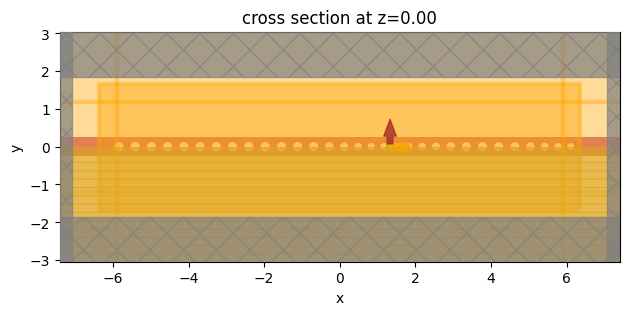

In [19]:
n_constant_structures_right = 2
n_tapered_output = 5

asymmetric_sim = create_simulation(
    unit_cell_function=unit_cell_function,
    wl1=wl1,
    wl2=wl2,
    width=width,
    height=height,
    run_time=run_time,
    lattice_constant=lattice_constant,
    n_constant_structures_right=n_constant_structures_right,
    n_constant_structures_left=n_constant_cells,
    n_tapered_output=5,
    n_tapered_structures=n_tapered_cells,
    max_dip_lattice=max_dip_lattice,
    polarization=polarization,
    substrate_index=substrate_index,
    unit_cell_index=unit_cell_index,
    waveguide_index=waveguide_index,
    sidewall_angle=sidewall_angle,
    original_params=[radius_x, radius_y],
    max_dip_params=[max_dip_lattice, max_dip_lattice],
)

asymmetric_sim.plot(z=0)
plt.show()

In [20]:
asymmetric_sim_data = web.run(asymmetric_sim, task_name="asymmetric_ellipse_nanobeam")

16:44:53 -03 Created task 'asymmetric_ellipse_nanobeam' with task_id            
             'fdve-3313404a-b9cb-42c3-a711-3532e96df5ca' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=163203;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3313404a-b9cb-42c3-a711-3532e96df5ca\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=816219;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3313404a-b9cb-42c3-a711-3532e96df5ca\taskId]8;;\]8;id=163203;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3313404a-b9cb-42c3-a711-3532e96df5ca\=]8;;\]8;id=45688;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3313404a-b9cb-42c3-a711-3532e96df5ca\fdve]8;;\]8;id=163203;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3313404a-b9cb-42c3-a711-3532e96df5ca\-3313404a-b9c]8;;\
             ]8;id=163203;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3313404a-b9cb-42c3-a711-3532e96df5ca\b-42c3-a711-3532e96df5ca']8;;\.

Output()

16:44:57 -03 status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

16:45:39 -03 status = preprocess

16:45:40 -03 Maximum FlexCredit cost: 0.179. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

16:47:36 -03 status = postprocess

Output()

16:48:12 -03 status = success

             View simulation result at                                          
             ]8;id=556018;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3313404a-b9cb-42c3-a711-3532e96df5ca\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=4346;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3313404a-b9cb-42c3-a711-3532e96df5ca\taskId]8;;\]8;id=556018;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3313404a-b9cb-42c3-a711-3532e96df5ca\=]8;;\]8;id=340585;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3313404a-b9cb-42c3-a711-3532e96df5ca\fdve]8;;\]8;id=556018;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3313404a-b9cb-42c3-a711-3532e96df5ca\-3313404a-b9c]8;;\
             ]8;id=556018;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3313404a-b9cb-42c3-a711-3532e96df5ca\b-42c3-a711-3532e96df5ca']8;;\.

Output()

16:48:57 -03 loading simulation from simulation_data.hdf5

16:48:58 -03 WARNING: Simulation final field decay value of 0.0561 is greater   
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

First, we will plot the fields and recalculate the Q-factor and mode volume.

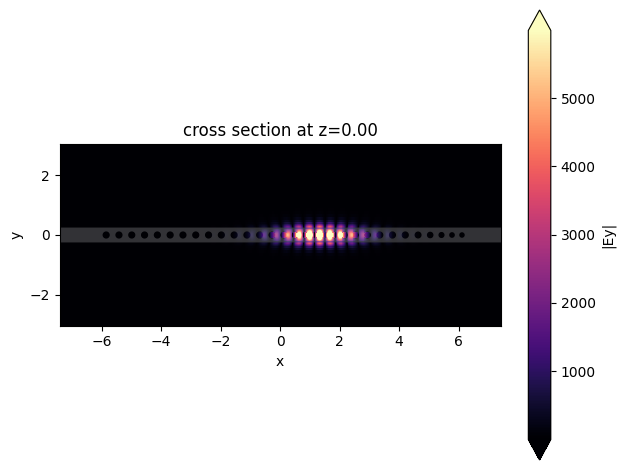

In [21]:
asymmetric_sim_data.plot_field(
    "fieldProfileMon",
    "Ey",
    val="abs",
    z=0,
    t=asymmetric_sim_data["fieldProfileMon"].Ez.t[-1],
)
plt.show()

In [22]:
asymmetric_energy_density, asymmetric_eps = get_energy_density(asymmetric_sim_data)
asymmetric_Vmode = mode_volume(asymmetric_energy_density, eps)

print("Mode volume: %.2f (lambda/n)^3" % asymmetric_Vmode)

asymmetric_df, asymmetric_signal = analyse_resonance_monitors(
    asymmetric_sim_data, start_time, freq_window
)
asymmetric_df.head()

Mode volume: 0.41 (lambda/n)^3


,decay,Q,amplitude,phase,error,wl
freq,,,,,,
1.941612e+14,1.635266e+08,3.730130e+06,18817.985879,-2.816392,0.000098,1544.038947


### Direction Q-factor definition

To calculate the directional Q-factors, we will use the definition:

$Q^i = \omega \frac{U_{stored}}{U^i_{lost}}$

Where $U_{stored}$ is the total energy in the resonator and $U^i_{lost}$ is the energy leaking from the resonator in one oscillation of the field at coordinate $i$. The energy stored is calculated by integrating the energy density. The energy leaving in each direction is calculated as the temporal mean of the flux monitors around the simulation domain.

In [23]:
def get_directional_Q(sim_data, energy_density, resonant_frequency):
    dict_fluxes = {}

    omega = 2 * np.pi * resonant_frequency

    # calculating the total energy
    Energy = td.EPSILON_0 * np.abs(energy_density).integrate(coord=("x", "y", "z"))

    # iterating through all flux monitors and calculating the Q factor
    for coord in ["x", "y", "z"]:
        for direction in ["", "-"]:
            delta_t = (
                sim_data[direction + coord].flux.t[-1]
                - sim_data[direction + coord].flux.t[0]
            )
            flux = abs(sim_data[direction + coord].flux.integrate(coord="t")) / delta_t
            dict_fluxes[direction + coord] = (omega * Energy / flux).values

    # estimating the total Q as the contributions of all directional Q factors
    totalQ = sum([1 / i for i in dict_fluxes.values()]) ** -1
    dict_fluxes["total Q"] = totalQ

    return dict_fluxes

In [24]:
resonant_frequency = abs(df.sort_values("Q").index[0])
directional_Q = get_directional_Q(
    asymmetric_sim_data, asymmetric_energy_density, resonant_frequency
)

for i in directional_Q.keys():
    print("Q %s = %.2f MM" % (i, directional_Q[i] * 10**-6))

Q x = 3.98 MM
Q -x = 93.30 MM
Q y = 18.91 MM
Q -y = 18.91 MM
Q z = 20.91 MM
Q -z = 20.91 MM
Q total Q = 2.16 MM


We can note that the x+ directional Q is lower than all the others, indicating that this is a preferential loss path. Also, the total Q calculated as the sum of all directional components agrees well with the one obtained using `ResonanceFinder`.